<a href="https://colab.research.google.com/github/MucaCirone/Master_Thesis/blob/main/Structured_CDE_rSig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install git+https://github.com/patrick-kidger/torchcde.git
!pip install git+https://github.com/crispitagorico/sigkernel.git

In [ ]:
import torch
import torchcde

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from scipy import linalg
import random


from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

import sigkernel

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Download files in https://github.com/HazyResearch/structured-nets/tree/master/pytorch/structure/hadamard_cuda.

Upload them here, one by one.

In [ ]:
!python setup.py install

from hadamard_cuda import hadamard_transform

# Structured rSig - CDE code

In [ ]:
def rademacher_sample(M) : 
  return torch.diag(2*(torch.rand(M) > 0.5).int() - 1).float().to(device)

def struct_weights(K, sigma = 1.):
  M = 2**K
  HD1 = hadamard_transform(rademacher_sample(M))
  HD2 = hadamard_transform(rademacher_sample(M))
  HD3 = hadamard_transform(rademacher_sample(M))

  W = torch.matmul(HD1,HD2)
  W = torch.matmul(W,HD3)

  return 1/(sigma*M)*W

In [ ]:
def randomAbeta(n_vec: int, m: int, mean=0.0, sigma=0.03, distribution=torch.normal):
    # Creates n_vec random mxm matrix A and mx1 vector beta
    # Entries have distribution 'distribution'

    K = int(np.log2(m))

    A = []
    beta = []
    Gamma = []

    for i in range(n_vec):
        B = struct_weights(K, sigma = 1.).to(device)
        A = A + [B]
        b = distribution(mean, sigma, size=(1,m)).squeeze(0).to(device)
        beta = beta + [b]
        Gamma = Gamma + [torch.cat((B,b.unsqueeze(-1)),1)]


    return [torch.stack(A),torch.stack(beta),torch.stack(Gamma)]

In [ ]:
class DrivingFields(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, sigma = 1.0):
        ######################
        # input_channels is the number of input channels in the data X. (Determined by the data.)
        # hidden_channels is the number of channels for z_t. (Determined by you!)
        ######################
        super(DrivingFields, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels

        _,_,self.Gamma = randomAbeta(input_channels,hidden_channels, sigma= sigma)

    def forward(self, t, z):
        # z : (batch, hidden_channels)
        batch = z.shape[0]
        z = torch.cat((z, torch.ones([batch,1]).to(device)),1) # z -> [z,1]
        z = z.unsqueeze(-2).unsqueeze(-1) # (batch,n+1) -> (batch,1,n+1,1)
        G = self.Gamma.expand(1,-1,-1,-1) # (d, n, n+1) -> (1, d, n, n+1)
        res = torch.matmul(G,z)           # (batch, d, n, 1) 
        res = res.squeeze(-1)             # (batch, d, n, 1) -> (batch, d, n)
        res = torch.swapaxes(res, -2, -1) # (batch, d, n) -> (batch, n, d)
        # res = res.sigmoid()
        return res

In [ ]:
def rademacher_sample(M) :
  # MxM Rademacher matrix
  # shape: (M, M)
  return torch.diag(2*(torch.rand(M) > 0.5).int() - 1).float().to(device)

def matrix_D(M,d):
  # d MxM Rademacher matrices. 
  # shape: (d, M, M)
  return torch.stack([rademacher_sample(M) for i in range(d)])

In [107]:
class structDrivingFields(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, sigma = 1.0,  sigma_ = 1.0):
        ######################
        # input_channels is the number of input channels in the data X. (Determined by the data.)
        # hidden_channels is the number of channels for z_t. (Determined by you!)
        ######################
        super(structDrivingFields, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.sigma_ = sigma_ 

        self.D1 = matrix_D(hidden_channels, input_channels).unsqueeze(0) # (1, d, n, n)
        self.D2 = matrix_D(hidden_channels, input_channels).unsqueeze(0)
        self.D3 = matrix_D(hidden_channels, input_channels).unsqueeze(0)
        self.b  = torch.normal(0., sigma, size = (input_channels, hidden_channels)).to(device)
        self.b  = self.b.unsqueeze(-1).unsqueeze(0)

    def forward(self, t, z):
        # z : (batch, hidden_channels)
        batch = z.shape[0]

        z = z.unsqueeze(1).unsqueeze(-1) # (batch,n) -> (batch, 1, n, 1)

        # Compute HD3*z
        z = hadamard_transform(torch.matmul(self.D3,z)) # (batch, d, n, 1)
        # Compute HD2*HD3z
        z = hadamard_transform(torch.matmul(self.D2,z)) # (batch, d, n, 1)
        # Compute HD1*HD2*HD3z
        z = hadamard_transform(torch.matmul(self.D1,z)) # (batch, d, n, 1)

        res = 1/(self.sigma_*self.hidden_channels)*z + self.b  # (batch, d, n, 1)
        res = res.squeeze(-1) # (batch, d, n, 1) -> (batch, d, n)
        res = torch.swapaxes(res, -2, -1) # (batch, d, n) -> (batch, n, d)
        # res = res.sigmoid()
        return res

In [129]:
######################
# Next, we need to package CDEFunc up into a model that computes the integral.
######################
class rSig(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels):
        super(rSig, self).__init__()
        sigma = 1/np.sqrt(hidden_channels)

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.fields = DrivingFields(input_channels, hidden_channels, sigma)
        self.z0 = sigma*torch.normal(0,1,size = [self.hidden_channels]).to(device)

    def forward(self, coeffs):
        batch = coeffs.shape[0]
        X = torchcde.interpolation_cubic.NaturalCubicSpline(coeffs)

        ######################
        # Easy to forget gotcha: Initial hidden state should be a function of the first observation.
        ######################
        X0 = X.evaluate(X.interval[0])
        z0 = (self.z0).expand(batch, -1)

        ######################
        # Actually solve the CDE.
        ######################
        z_T = torchcde.cdeint(X=X,
                              z0=z0,
                              func=self.fields,
                              t=X.interval)

        ######################
        # Both the initial value and the terminal value are returned from cdeint; extract just the terminal value,
        # and then apply a linear map.
        ######################
        z_T = z_T[:, 1]
        return z_T

# Data

Daily Bitcoin to USD prices data from https://www.cryptodatadownload.com/. 

Make sure to download the daily BTC/USD data from the page https://www.cryptodatadownload.com/data/gemini/ and to upload to your instance of colab. The file should be named "*Gemini_BTCUSD_d.csv*".

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return 100.*np.mean(np.abs((y_true - y_pred) / y_true)) 

#Helper function that extract rolling windows of historical prices of size h and means of the next future f prices.
def GetWindow(x, h_window=30, f_window=10):

    # First window
    X = np.array(x.iloc[:h_window,]).reshape(1,-1) # first h_window elements as h_window x 1 np vector
   
    # Append next window
    for i in range(1,len(x)-h_window+1):
        x_i = np.array(x.iloc[i:i+h_window,]).reshape(1,-1)
        X = np.append(X, x_i, axis=0)
        
    # Cut the end that we can't use to predict future price
    rolling_window = (pd.DataFrame(X)).iloc[:-f_window,]
    return rolling_window

def GetNextMean(x, h_window=30, f_window=10):
    return pd.DataFrame((x.rolling(f_window).mean().iloc[h_window+f_window-1:,]))

def PlotResult(y_train, y_test, y_train_predict, y_test_predict, name):
    
    train_len = len(y_train)
    test_len = len(y_test)
    
    #Visualise
    fig, ax = plt.subplots(1, figsize=(12, 5))
    ax.plot(y_train_predict,color='red')

    ax.plot(range(train_len, train_len+test_len),
            y_test_predict,
            label='Predicted average price',
            color='red',linestyle = '--')

    ax.plot(np.array((y_train).append(y_test)),
             label='Actual average price',
             color='green')

    ax.axvspan(len(y_train), len(y_train)+len(y_test),
                alpha=0.3, color='lightgrey')

    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best")
    plt.xlabel('Days')
    plt.ylabel('Bitcoin prices')
    #plt.savefig('../pictures/bitcoin_prices_prediction_{}'.format(name))
    plt.show()

In [ ]:
import pandas as pd

# load data (source is https://www.cryptodatadownload.com)
BTC_price = pd.read_csv('/content/Gemini_BTCUSD_d.csv',header=1)

# drop the first column and reverse order
BTC_price = BTC_price.iloc[1:,:]
BTC_price = BTC_price.iloc[::-1]
BTC_price['date'] = pd.to_datetime(BTC_price['date'])
BTC_price.set_index('date', inplace=True)

# select duration
initial_date = '2017-06-01'
finish_date = '2018-08-01'
BTC_price = BTC_price.loc[BTC_price.index >= initial_date]
BTC_price = BTC_price.loc[BTC_price.index <= finish_date]

In [ ]:
# use only close price
close_price = BTC_price.loc[:,'close']
close_price = pd.DataFrame(np.squeeze(close_price))

# use last h_window observations to predict mean over next f_window observations
h_window = 36
f_window = 2

# next mean price
y = GetNextMean(close_price, h_window=h_window , f_window=f_window)

# normal window features
X_window = GetWindow(close_price, h_window, f_window).values
X_window = torch.tensor(X_window, dtype=torch.float64)
X_window = sigkernel.transform(X_window, at=True, ll=True, scale=1e-5)

# train test split
x_train, x_test, y_train, y_test = train_test_split(X_window, y, test_size=0.2, shuffle=False)
x_train = torch.tensor(x_train, dtype=torch.float64).to(device)
x_test = torch.tensor(x_test, dtype=torch.float64).to(device)

# x_train.shape = (311, 71, 3)

The price data has been augmented by adding a time dimension and a lead lag transformation (see Terry Lyons' "*Rough paths, Signatures and the modelling of functions on streams*" at https://arxiv.org/abs/1405.4537)

# rSig

In [ ]:
from torch.nn.functional import normalize

x_train_ = normalize(x_train, dim=2)
x_test_ = normalize(x_test, dim=2)

In [ ]:
# hyperparameters for grid search
#svr_parameters = {'C': np.logspace(0, 4, 5), 'gamma': np.logspace(-4, 4, 9)}
svr_parameters= {'C': np.array([1.0]), 'gamma': np.array([1.e-04])}

In [ ]:
MC_iterations = 15
hidden_dim = 32

In [130]:
from tqdm import tqdm

X = torch.cat([x_train_, x_test_],0)

N = x_train_.shape[0]
M = x_test_.shape[0]

Gram_train = torch.zeros((MC_iterations, N, N)).to(device)
Gram_test = torch.zeros((MC_iterations, M, N)).to(device)

for m in tqdm(range(MC_iterations)):

  model = rSig(input_channels = 3, hidden_channels = hidden_dim)

  coeffs = torchcde.natural_cubic_coeffs(X).float()
  S = model.forward(coeffs)

  sigs_train = S[:N]
  sigs_test = S[N:]

  Gram_train[m] = sigs_train@sigs_train.T
  Gram_test[m] = sigs_test@sigs_train.T

Gram_train = torch.mean(Gram_train, dim=0).detach().cpu().numpy()
Gram_test = torch.mean(Gram_test, dim=0).detach().cpu().numpy()

100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Fitting 5 folds for each of 1 candidates, totalling 5 fits
4.277128536842021
2.9573880892823814



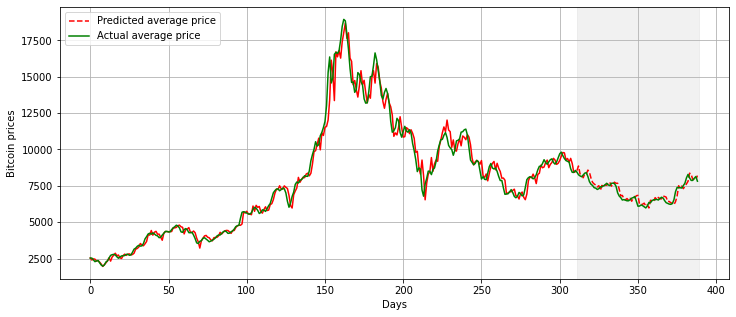

In [131]:
# fit the model
svr = SVR(kernel='precomputed')
svr_pde = GridSearchCV(estimator=svr, param_grid=svr_parameters, cv=5, n_jobs=-1, verbose = 4)
svr_pde.fit(Gram_train, np.squeeze(y_train))

# predict
y_train_predict = svr_pde.predict(Gram_train)
y_test_predict = svr_pde.predict(Gram_test)  

# calculate errors
p_error_train = mean_absolute_percentage_error(np.array(y_train).reshape(-1,1), np.array(y_train_predict).reshape(-1,1))
p_error_test = mean_absolute_percentage_error(np.array(y_test).reshape(-1,1), np.array(y_test_predict).reshape(-1,1))

print(p_error_train)
print(p_error_test)
print("")

# plot results
PlotResult(y_train, y_test, y_train_predict, y_test_predict, 'rSig')

# Problems...

In [98]:
d = 3
n = 4
batch = 2

z = torch.tensor([[1.0,0.,0, 0],[0,1.,0, 0]]).to(device)
z = z.unsqueeze(1).unsqueeze(-1) # (batch, 1, n, 1)
z_ = z

D1 = matrix_D(n,d).unsqueeze(0) # (1, d, n, n)
D2 = matrix_D(n,d).unsqueeze(0)
D3 = matrix_D(n,d).unsqueeze(0)

# Compute HD3*z
z = hadamard_transform(torch.matmul(D3,z)) # (batch, d, n, 1)
# Compute HD2*HD3z
z = hadamard_transform(torch.matmul(D2,z)) # (batch, d, n, 1)
# Compute HD1*HD2*HD3z
z = hadamard_transform(torch.matmul(D1,z)) # (batch, d, n, 1)

In [99]:
z[0]

tensor([[[-1.],
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 1.],
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 1.],
         [ 0.],
         [ 0.],
         [ 0.]]], device='cuda:0')

In [111]:
i = 1

HD3 = hadamard_transform(D3[0,i])
HD2 = hadamard_transform(D2[0,i])
HD1 = hadamard_transform(D1[0,i])

W = torch.matmul(HD1,HD2)
W = torch.matmul(W,HD3)

In [123]:
torch.matmul(hadamard_transform(D3[0,i]), z_[0,0])

tensor([[ 1.],
        [ 1.],
        [-1.],
        [-1.]], device='cuda:0')

In [122]:
hadamard_transform(torch.matmul(D3,z_)[0,i])

tensor([[1.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [116]:
hadamard_transform(torch.matmul(D3,z_))[0]

tensor([[[1.],
         [0.],
         [0.],
         [0.]],

        [[1.],
         [0.],
         [0.],
         [0.]],

        [[1.],
         [0.],
         [0.],
         [0.]]], device='cuda:0')

In [112]:
torch.matmul(W, z_[0,0])

tensor([[-4.],
        [ 4.],
        [-4.],
        [-4.]], device='cuda:0')

In [127]:
 diag1 = 2 * torch.randint(0, 2, (4, )).to(device) - 1

In [128]:
diag1

tensor([-1,  1, -1, -1], device='cuda:0')